## Mathematical Simulation in Python, Billiard Dynamical Systems
### Summer Workshop in Mathematics, University of Brasilia
### Summer 2018, Session 3, Scott Cook

Goal: Implement the "No-Slip" collision of Chris Cox and Renato Feres.  See:
- https://github.com/drscook/unb_billiards/blob/master/references/Non-standard%20billiards/No%20Slip%20law/broomhead_gutkin_1992.pdf - first introduction of the no-slip law, restricted to 2 dimensional collisions
- https://github.com/drscook/unb_billiards/blob/master/references/Non-standard%20billiards/No%20Slip%20law/cox_feres_2016.pdf - Simulation study of no-slip billiard systems
- https://github.com/drscook/unb_billiards/blob/master/references/Non-standard%20billiards/No%20Slip%20law/cox_feres_ward_2015.pdf - Theoretical classification of collision laws
- https://github.com/drscook/unb_billiards/blob/master/references/Non-standard%20billiards/No%20Slip%20law/cox_feres_zhang2018.pdf - Stability study of no-slip billiard systems
- https://github.com/drscook/unb_billiards/blob/master/references/Non-standard%20billiards/No%20Slip%20law/feres_N_dim_no_slip_law_2017.pdf - Derivation of no-slip collision law in arbitrary dimension last 2 pages (handwritten notes from Renato Feres - to be published)

We will implement the version that works in any dimension derived in Renato Feres's notes (last reference above).  It is much easier to *understand* the derivation in 2 dimensions in Broomhead and Gutkin's 1992 paper, but we will code the more general version in arbitrary dimension.

To do this, we need to implement angular positions and velocities.  See https://en.wikipedia.org/wiki/Rotation_matrix.  Let d = dimension
- angular position
    - Variable name = orient
    - $d \times d$ orthogonal matrix
    
- angular velocity
    - Variable name = spin
    - $d \times d$ skew-symmetric matrix
- evolution between collisions:
    - Say the particle leaves a collision with orientation $A$ and spin $U$ and travels for time $t$.  Then the new orientation $A' = e^{t U} A$, where $e$ is the matrix exponential https://en.wikipedia.org/wiki/Matrix_exponential.
- Collision between 2 particles:
    - Denote the state of a particle with a 4-tuple (pos, vel, orient, spin).
        - $(a_1^-, u_1^-, A_1^-, U_1^-)$ be incoming state of particle 1
        - $(a_2^-, u_2^-, A_2^-, U_2^-)$ be incoming state of particle 2
        - $(a_1^+, u_1^+, A_1^+, U_1^+)$ be outgoing state of particle 1
        - $(a_2^+, u_2^+, A_2^+, U_2^+)$ be outgoing state of particle 2
    - Clearly $a_1^- = a_1^+$, $a_2^+ = a_2^+$ because position does not change during a collision
    - Clearly $A_1^- = A_1^+$, $A_2^+ = A_2^+$ because orientation does not change during a collision
    - The remaining + variables are given in terms of the - variables by the no-slip collision law on p.23 of https://github.com/drscook/unb_billiards/blob/master/references/Non-standard%20billiards/No%20Slip%20law/feres_N_dim_no_slip_law_2017.pdf

### Step 1 - Implement orientation and spin variables

This will involve 2 types of variables:
- physical constants
    - refs
        - Dim 2 - http://ec2-54-242-24-75.compute-1.amazonaws.com:8000/user/scook/files/unb_billiards/references/Non-standard%20billiards/No%20Slip%20law/cox_feres_zhang2018.pdf, page 4
        - Dim d - https://github.com/drscook/unb_billiards/blob/master/references/Non-standard%20billiards/No%20Slip%20law/feres_N_dim_no_slip_law_2017.pdf, page 1
    - radius $r$
    - mass $m$
    - mass distribution $\gamma$
        - $0 \leq \gamma \leq \sqrt{2/d}$
        - $\gamma = 0 \implies$ all mass at center (point mass)
        - $\gamma = \sqrt{2/(2+d)} \implies$ uniform mass distribution
        - $\gamma = \sqrt{2/d} \implies$ mass along boundary (shell)
    - Moment of inertia $I = m * (\gamma * r)^2$
- dynamical quantites
    - translation
        - position
        - velocity
    - rotation
        - orientation
        - spin

Sadly, we need quite a few helper function to make this work nicely.  We have added/changed the following to version 3a billiard_def:
- wp_no_slip_law (method of Wall)
- \__init\__ of Particle to record $\gamma$ and compute $I$
- Added equator to particles so we can see the spin
- smoother - interpolates between collisions AND computes correct orientation
- Several support functions
    - make_symmetric - converts any square matrix into symmetric or skew-symmetric based on its upper triangle
    - spin_matrix_from_vector and spin_vector_from_matrix - Because spin is skew-symmetric, we only need to track its upper triangle.  These converts between the $d \times d$ skew-symmteric matrix and the $d(d-1)/2$ vector.  See https://en.wikipedia.org/wiki/Rotation_matrix#Rotation_matrix_from_axis_and_angleSee for the conventional way to do so. 
    - wedge, Pi_nu, Pi, Lambda_nu, E_nu, Gamma_nu - functions defined in Feres's notes for the arbtrary dimenional no-slip law
    - random_uniform_sphere and random_uniform_ball - choose uniformly at random from n-dim sphere or ball
    

In [28]:
%matplotlib inline
seed = 10
# Note we use version 3a now
%run -i billiard_defs_3a.py

dim = 2
R_particle = 1.0
R_scatter = 10.0

R = R_particle + R_scatter
gap_crit = (2/np.sqrt(3) - 1) * R
gap = 0.99 * gap_crit

x0 = R + gap
y0 = np.sqrt(3) * x0

wall = [FlatWall(dim=dim, base_point=[-x0, 0], normal=[1, 0], tangents=[[0, y0]], gap_pad=R_particle, wp_collision_law='wp_no_slip')
        ,FlatWall(dim=dim, base_point=[x0, 0], normal=[-1, 0], tangents=[[0, -y0]], gap_pad=R_particle, wp_collision_law='wp_no_slip')
        ,FlatWall(dim=dim, base_point=[0, -y0], normal=[0, 1], tangents=[[-x0, 0]], gap_pad=R_particle, wp_collision_law='wp_no_slip')
        ,FlatWall(dim=dim, base_point=[0, y0], normal=[0, -1], tangents=[[x0, 0]], gap_pad=R_particle, wp_collision_law='wp_no_slip')
        ,SphereWall(dim=dim, base_point=[0,0], radius=R_scatter, gap_pad=R_particle, wp_collision_law='wp_no_slip')
#         ,SphereWall(dim=dim, base_point=[-x0, -y0], radius=R_scatter, gap_pad=R_particle)
#         ,SphereWall(dim=dim, base_point=[x0, -y0], radius=R_scatter, gap_pad=R_particle)
#         ,SphereWall(dim=dim, base_point=[-x0, y0], radius=R_scatter, gap_pad=R_particle)
#         ,SphereWall(dim=dim, base_point=[x0, y0], radius=R_scatter, gap_pad=R_particle)
       ]
for (i, w) in enumerate(wall):
    w.idx = i

num = 2
part = Particles(max_steps=10, cell_size=[x0, y0], dim=dim, num=num
                 , mass  = 1.0
                 , radius= R_particle
                 , gamma = 'uniform'
                )
part.cell_size = [x0, y0]

theta = rnd.uniform(0, 2*np.pi, num)
part.pos = 1.01 * wall[4].wp_gap_min * np.asarray([np.cos(theta), np.sin(theta)]).T

theta = rnd.uniform(0, 2*np.pi, num)
speed = 1.0
part.vel = speed * np.asarray([np.cos(theta), np.sin(theta)]).T

part.orient = np.asarray([np.eye(part.dim)
                          for p in range(part.num)]).astype(float)

speed = 1.0
m = int(part.dim*(part.dim-1)/2)
part.spin = np.asarray([spin_matrix_from_vector([random_uniform_sphere(num=1, dim=m, radius=speed)])
                        for p in range(part.num)]).astype(float)


part.KE_init = part.get_KE().sum()
part.record_state()
for step in range(part.max_steps):
    next_state(wall, part)

clean_up(part)
smoother(part,min_frames=1)
interactive_plot()

Done!! Steps = 10, Time = 64.167392


HBox(children=(VBox(children=(BoundedIntText(value=0, layout=Layout(width='150px'), max=180), IntSlider(value=0, continuous_update=False, layout=Layout(width='150px'), max=180, readout=False), Play(value=0, interval=500, layout=Layout(width='150px'), max=180))), Output()))

Exercises: https://github.com/drscook/unb_billiards/blob/master/references/Non-standard%20billiards/No%20Slip%20law/cox_feres_2016.pdf

1. Reproduce fig5 on p.6
2. Or fig6 on p.7
3. Or fig9 on p.10
4. Or fig10 on p.10
5. Or some other systems that looks interested to you

In [1]:
%%time
%matplotlib inline
seed = 42
# Note we use version 3a now
%run -i billiard_defs_3a.py

dim = 2
R_particle = 1.0
x0 = 100000*R_particle
y0 = 5*R_particle

wall = [FlatWall(dim=dim, base_point=[0, -y0], normal=[0, 1], tangents=[[-x0, 0]], gap_pad=R_particle, wp_collision_law='wp_no_slip')
        ,FlatWall(dim=dim, base_point=[0, y0], normal=[0, -1], tangents=[[x0, 0]], gap_pad=R_particle, wp_collision_law='wp_no_slip')
        ]
for (i, w) in enumerate(wall):
    w.idx = i

num = 2
part = Particles(max_steps=1000, cell_size=[x0, y0], dim=dim, num=num
                 , mass  = 1.0
                 , radius= R_particle
                 , gamma = 'uniform'
                )
part.cell_size = [x0, y0]

theta = rnd.uniform(0, 2*np.pi, num)
part.pos = np.asarray([[p*3*R_particle, 0.0] for p in range(part.num)])

theta = rnd.uniform(0, 2*np.pi, num)
speed = 1.0
part.vel = speed * np.asarray([np.cos(theta), np.sin(theta)]).T

part.orient = np.asarray([np.eye(part.dim)
                          for p in range(part.num)]).astype(float)

speed = 1.0
m = int(part.dim*(part.dim-1)/2)
part.spin = np.asarray([spin_matrix_from_vector([random_uniform_sphere(num=1, dim=m, radius=speed)])
                        for p in range(part.num)]).astype(float)


part.KE_init = part.get_KE().sum()
part.record_state()
for step in range(part.max_steps):
    next_state(wall, part)

clean_up(part)
smoother(part,min_frames=1)
m = np.min(part.re_pos[:,:,0])-5*R_particle
M = np.max(part.re_pos[:,:,0])+5*R_particle
wall[0].mesh = np.asarray([[m,-y0],[M,-y0]])
wall[1].mesh = np.asarray([[m,y0],[M,y0]])
# interactive_plot()
draw_state()

Done!! Steps = 1000, Time = 5076.453698


NameError: name 'draw_hist' is not defined

NameError: name 's' is not defined

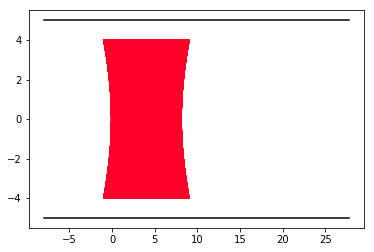

In [2]:
draw_state()